## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# Import libraries
# from <TC_Env> import <TicTacToe> - import your class from environment file

import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

from TCGame_Env_AmitGoel import TicTacToe
import time 

%matplotlib inline

#### Few utility functions

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 

def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy_policy(state, episode):
    
    # As per provided at the end of notebook
    max_epsilon = 1.0
    min_epsilon = 0.001
    decay_rate = 0.000001
    
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
    
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get) # Max Q value action
    else:
        valid_act = valid_actions(state)
        action = random.choice(valid_act) # Random choice as any other action
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked

def initialise_tracking_states():
    state_action_pairs = [('x-x-x-x-x-x-x-x-x', (7, 3)),
                          ('x-x-6-x-x-x-x-3-x', (8, 9)),
                          ('4-x-x-x-x-x-x-x-1', (7, 5)),
                          ('x-x-2-x-x-x-x-x-1', (5, 5)),
                          ('x-x-x-x-x-8-3-x-x', (4, 7)),
                          ('9-x-x-x-x-x-x-x-8', (2, 7)),
                          ('x-x-x-x-6-x-1-x-x', (3, 9)),
                          ('6-x-x-x-7-x-x-x-x', (2, 9))]
    
    for state, action in state_action_pairs:
        States_track[state][action] = []

In [8]:
# Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
# Defining a function to save states being tracked

def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
# Initialize states being tracked

initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
EPISODES = 5000000

# After trying different LR and GAMMA combination, below is chosen which helps in more number of wins for agent
LR=0.01
GAMMA = 0.90

STATES_TRACKING = 5000 # Save states being tracked after every 5000 episodes
EPISODE_TRACKING = 50000 # Print episode number after every 50000 episodes, just to know progress

### Q-update loop ---write your code here

In [12]:
# Q-update loop

start_time = time.time()

agent_count = 0
env_count = 0
tie_count = 0

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    
    env = TicTacToe() # Initialize environment with every episode
    
    curr_state = env.state # Get current state from environment
   
    # Adding current state to dictionary
    add_to_dict(curr_state)

    is_terminal_state = False # Setup variable for terminal state check
    
    while is_terminal_state != True:
        
        curr_state_1 = Q_state(curr_state) # Converted to string
        
        # Applying epsilon greedy policy
        curr_action = epsilon_greedy_policy(curr_state, episode)   
        
        # Getting reward, next state and if state is terminal
        next_state, reward, is_terminal_state, result = env.step(curr_state, curr_action)
        
        add_to_dict(next_state) # Adding next state to dictionary
        
        next_state_1 = Q_state(next_state) # Converted to string

        max_action = None # Best action from next state - Reset every time
        
        # Updating rules
        if is_terminal_state != True:
            
            # Get best action corresponding to next state from Q - dictionary
            max_action = max(Q_dict[next_state_1],key=Q_dict[next_state_1].get)
            
            # Update Q-value of current state and action pair
            Q_dict[curr_state_1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_1][max_action])))
                                                      - Q_dict[curr_state_1][curr_action])
        else:
            
            # Terminal state - either a tie or a win by agent or a win by environment
            # Need to track who wins so can understand if agent is learning better
            
            if result == "Agent":
                agent_count += 1

            elif result == "Environment":
                env_count += 1
                
            else:
                tie_count += 1
                
            # Update Q-value of current state and action pair
            Q_dict[curr_state_1][curr_action] += LR * ((reward - Q_dict[curr_state_1][curr_action]))

        # Move to next state
        curr_state = next_state
        
    # Save states being tracked
    if ((episode+1)%STATES_TRACKING)==0:
        save_tracking_states()
        
    # Track episodes just to know progress
    if ((episode+1)%EPISODE_TRACKING)==0:
        print("Episode : " + str(episode))        

elapsed_time = time.time() - start_time
save_obj(States_track,'States_Tracked')
save_obj(Q_dict,'Q_Policy')

print("Elapsed time :", elapsed_time)

Episode : 49999
Episode : 99999
Episode : 149999
Episode : 199999
Episode : 249999
Episode : 299999
Episode : 349999
Episode : 399999
Episode : 449999
Episode : 499999
Episode : 549999
Episode : 599999
Episode : 649999
Episode : 699999
Episode : 749999
Episode : 799999
Episode : 849999
Episode : 899999
Episode : 949999
Episode : 999999
Episode : 1049999
Episode : 1099999
Episode : 1149999
Episode : 1199999
Episode : 1249999
Episode : 1299999
Episode : 1349999
Episode : 1399999
Episode : 1449999
Episode : 1499999
Episode : 1549999
Episode : 1599999
Episode : 1649999
Episode : 1699999
Episode : 1749999
Episode : 1799999
Episode : 1849999
Episode : 1899999
Episode : 1949999
Episode : 1999999
Episode : 2049999
Episode : 2099999
Episode : 2149999
Episode : 2199999
Episode : 2249999
Episode : 2299999
Episode : 2349999
Episode : 2399999
Episode : 2449999
Episode : 2499999
Episode : 2549999
Episode : 2599999
Episode : 2649999
Episode : 2699999
Episode : 2749999
Episode : 2799999
Episode : 2849

In [13]:
# Check number of episodes of agent wins, environment wins and tie

print('Number of episodes in which there was a Tie - {0}'.format(tie_count))
print('Number of episodes in which Environment Won - {0}'.format(env_count))
print('Number of episodes in which Agent Won - {0}'.format(agent_count))

Number of episodes in which there was a Tie - 279182
Number of episodes in which Environment Won - 461153
Number of episodes in which Agent Won - 4259665


#### Check the Q-dictionary

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 3.280177410789511,
              (0, 3): 3.902964337963618,
              (0, 5): 2.963233167560729,
              (0, 7): -0.6300451672375851,
              (0, 9): -0.09027710039530161,
              (1, 1): 3.36415267305617,
              (1, 3): 4.122214091678458,
              (1, 5): 3.4722639733740865,
              (1, 7): -0.8286498462852943,
              (1, 9): 0.3318202850467993,
              (2, 1): 3.699213033348639,
              (2, 3): 3.9538362651769976,
              (2, 5): 3.6484566467219737,
              (2, 7): -0.23669136757755982,
              (2, 9): -1.4328853051388424,
              (3, 1): 3.3029272491144175,
              (3, 3): 5.27172963738561,
              (3, 5): 5.0869062193165595,
              (3, 7): 0.23225655212195465,
              (3, 9): -0.5850380067170954,
              (4, 1): 3.447620062413402,
              (4, 3): 3.336181749271959,
              (4, 5): 3.534880719588197

In [15]:
len(Q_dict)

1133685

In [16]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

best_action = max(Q_dict['x-x-6-x-x-x-x-3-x'],key=Q_dict['x-x-6-x-x-x-x-3-x'].get)
print(best_action)
Q_dict['x-x-6-x-x-x-x-3-x']

(0, 9)


{(0, 1): -0.0938801194821955,
 (0, 5): -0.15531847448161218,
 (0, 7): -0.5358010531108199,
 (0, 9): 9.744820355477088,
 (1, 1): -0.0763907691630799,
 (1, 5): -0.12712516850871505,
 (1, 7): -0.2808056054442002,
 (1, 9): 1.3125418723102171,
 (3, 1): -0.1304875570185252,
 (3, 5): -0.1225197363549954,
 (3, 7): -0.2833027197623708,
 (3, 9): -0.13911117513372634,
 (4, 1): -0.2963785426637557,
 (4, 5): -0.10757053937051468,
 (4, 7): -0.18851286918737356,
 (4, 9): 0.956179249911955,
 (5, 1): -0.2725653308674092,
 (5, 5): -0.0856006625163591,
 (5, 7): -0.35712164955142545,
 (5, 9): 0.6793465209301,
 (6, 1): -0.09298894394628551,
 (6, 5): -0.1277337650965608,
 (6, 7): -0.23577456117347487,
 (6, 9): 0.864827525163591,
 (8, 1): -0.15681831570879068,
 (8, 5): -0.2049670324975782,
 (8, 7): -0.3968034656386053,
 (8, 9): 1.2247897700103203}

#### Above is one of states which were being tracked - ('x-x-6-x-x-x-x-3-x', (8, 9)) - 2nd in the state-action pairs.

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [17]:
# Get no of iterations for state-action pair tracked

state_values = collections.defaultdict(dict)

for state in States_track.keys():
    for action in States_track[state].keys():
        qvals = States_track[state][action]
        total_tracked_values = len(qvals) # no of iterations
        state_values[state][action] = total_tracked_values
            
state_values

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(7, 3): 1000},
             'x-x-6-x-x-x-x-3-x': {(8, 9): 999},
             '4-x-x-x-x-x-x-x-1': {(7, 5): 1000},
             'x-x-2-x-x-x-x-x-1': {(5, 5): 1000},
             'x-x-x-x-x-8-3-x-x': {(4, 7): 1000},
             '9-x-x-x-x-x-x-x-8': {(2, 7): 1000},
             'x-x-x-x-6-x-1-x-x': {(3, 9): 1000},
             '6-x-x-x-7-x-x-x-x': {(2, 9): 1000}})

In [18]:
# Function to show convergence plot

def plot_q_val_convergence(state, action):

    iterations = state_values[state][action]

    plt.plot(range(0, iterations), States_track[state][action])
    
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - action : {1}".format(state, action))
    
    plt.legend(["Q-value"], loc="lower right")

<Figure size 1440x1080 with 0 Axes>

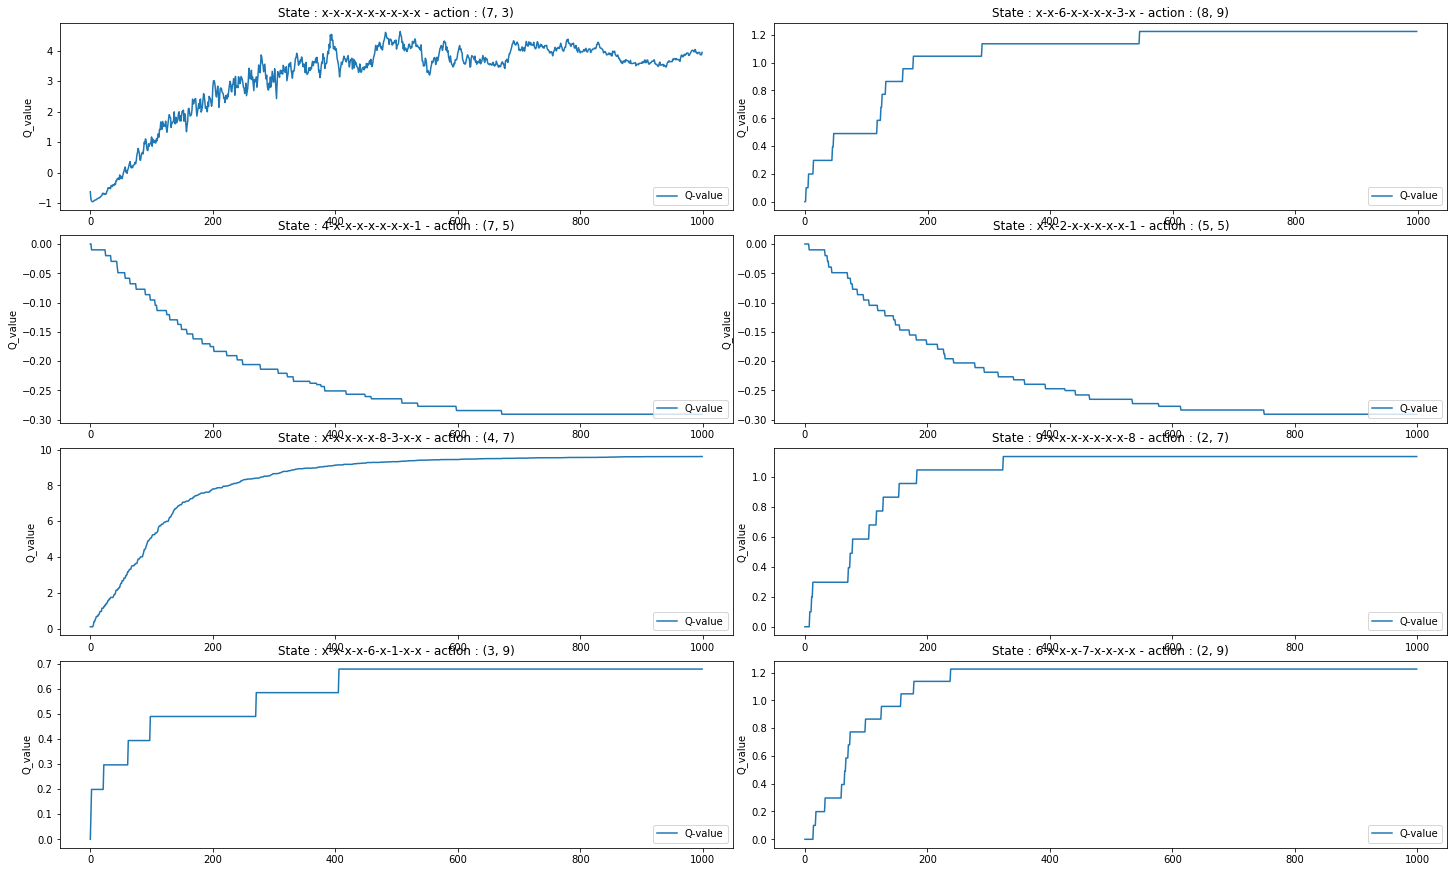

In [19]:
# Write the code to plot graphs for state-action pairs tracked to show convergence

plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(521,529)]

i = 0

for state in state_values.keys():
    for action in state_values[state].keys():
        plt.subplot(subplots[i])
        plot_q_val_convergence(state, action)
        i+=1

plt.show()

### All 8 state-action pairs which were being tracked, are converged as shown in above plots.

### Epsilon - decay check

In [20]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

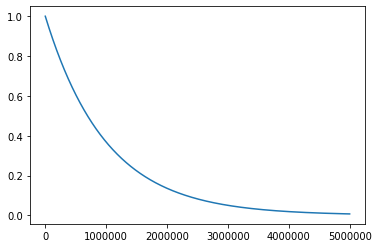

In [21]:
plt.plot(time, epsilon)
plt.show()